# Clustering methods

In this notebook, we will experiment with different clustering methods to see their differences, advantages and disadvantages. Some of the code in this notebook is taken from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from numpy.random import multivariate_normal

C:\Users\frbj\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's make some different datasets to play around with.

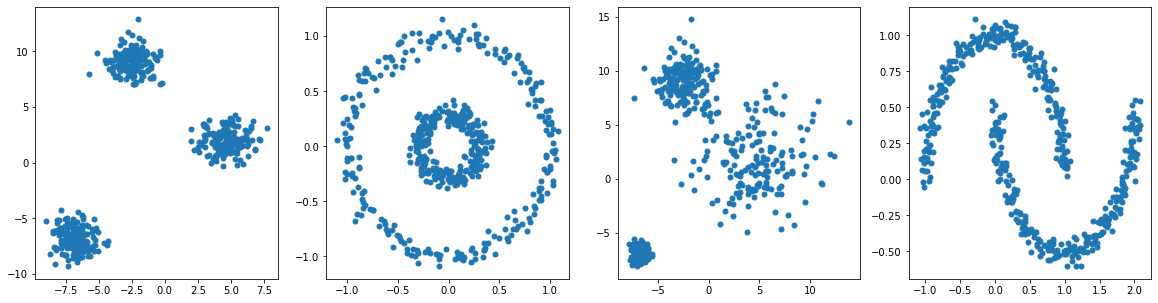

In [2]:
seed = 42
n_samples = 500
X1, y1 = make_blobs(n_samples=n_samples, n_features=2, centers=3, random_state=seed)
X2, y2 = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=seed)
X3, y3 = make_blobs(n_samples=n_samples, cluster_std=[1.5, 3, 0.5], random_state=seed)
X4, y4 = make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(zip(axes.ravel())):
    X = eval("X" + str(i+1)) #this is bad style, but it works
    ax[0].plot(X[:, 0],X[:, 1],'.', markersize=10)
plt.show()

## _k_-means clustering

Let's do _k_-means clustering on each of the datasets and plot the results. First, we'll use the elbow method to find a good value of _k_.

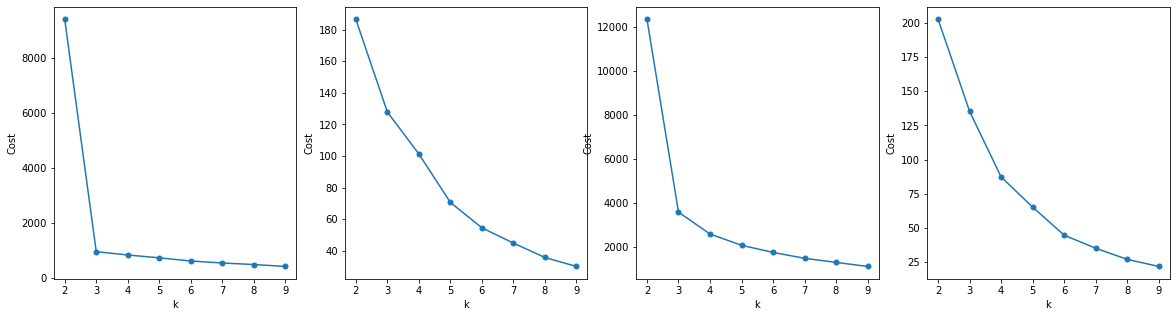

In [3]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(zip(axes.ravel())):
    X = eval("X" + str(i+1)) #this is bad style, but it works
    costs = []
    ks = range(2,10)
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        costs.append(kmeans.inertia_)
    ax[0].plot(ks,costs,'.-', markersize=10)
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Cost')
plt.show()

For the first and the third dataset, the elbow method clearly tells us to use _k_ = 3. For the second and the fourth, it is much harder to find a good value using this method. Now, we _know_ - from visual inspection of the data - that _k_ = 2 is the right value, as the elbows are much less obvious. Nevertheless, let's use _k_ = 5 and _k_ = 4, respectively, as this is where the elbows seem to be - but be aware that an ambiguous elbow chart could be a sign that _k_-means is not appropriate!

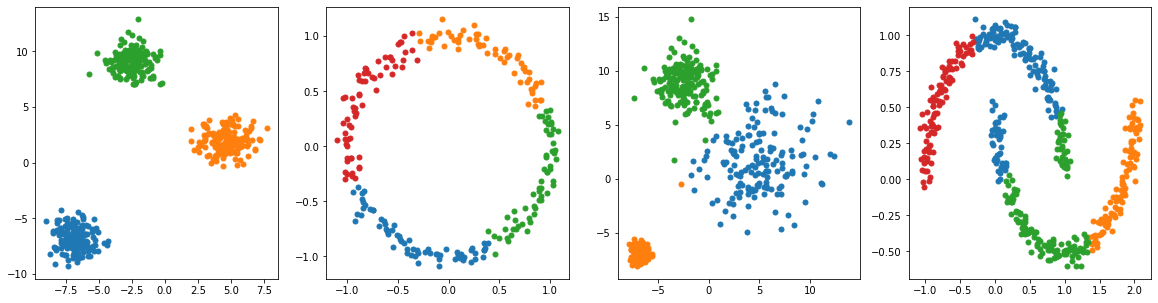

In [15]:
def plot_k_means(ks):
    fig, axes = plt.subplots(1,4, figsize = (20,5))
    for i, ax in enumerate(zip(axes.ravel())):
        X = eval("X" + str(i+1)) #this is still bad style, but it works
        kmeans = KMeans(n_clusters=ks[i])
        label = kmeans.fit_predict(X)
        for i in range(k):
            ax[0].plot(X[label == i , 0] , X[label == i , 1], '.', markersize=10, label = i)
    plt.show()
    
plot_k_means([3, 5, 3, 4])

This nicely illustrates where _k_-means performs well and where it does not.
* The first case works very well.
* The second is actually not that bad, although four of the clusters are really one.
* The third is ok, although _k_-means have trouble with different cluster sizes - the small clusters "steal" some points from the large one.
* The fourth cannot be handled by _k_-means at all (as we already suspected from the elbow charts!).

We can also try the "real" of _k_ - domain knowledge tells us to use 3, 2, 3 and 2, respectively.

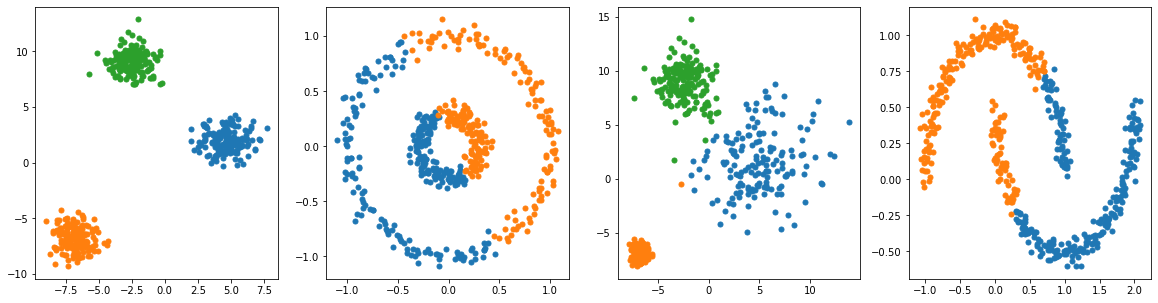

In [5]:
plot_k_means([3, 2, 3, 2])

Neither the elbow chart nor our domain knowledge really solves the second and fourth case: We need to do something other than _k_-means.

## Agglomerative clustering

First, we'll draw some dendrograms to find the number of clusters.

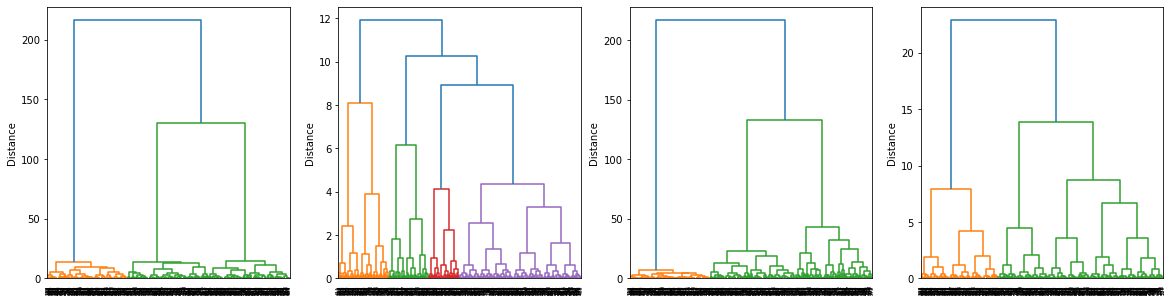

In [6]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(zip(axes.ravel())):
    X = eval("X" + str(i+1))
    linkage_array = ward(X) #compute distances using Ward's method
    dendrogram(linkage_array, ax = ax[0])
    ax[0].set_ylabel('Distance')
plt.show()

We identify the _longest_ vertical segment without any merging and count how many vertical lines there are in that segment, and get 3, 5, 3 and 2 clusters, respectively. With these values, let's see the clusters:

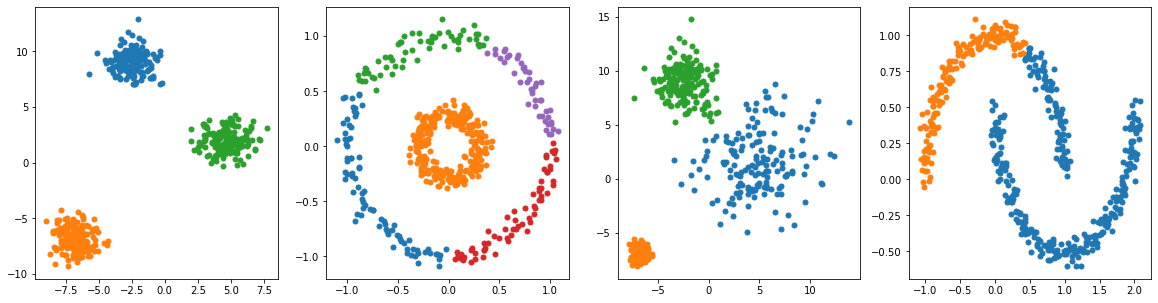

In [7]:
def plot_agg_clustering(ks, method):
    fig, axes = plt.subplots(1,4, figsize = (20,5))
    for i, ax in enumerate(zip(axes.ravel())):
        X = eval("X" + str(i+1))
        agg = AgglomerativeClustering(n_clusters=ks[i], linkage = method)
        label = agg.fit_predict(X)
        for i in range(k):
            ax[0].plot(X[label == i , 0] , X[label == i , 1], '.', markersize=10, label = i)
    plt.show()
    
plot_agg_clustering([3, 5, 3, 2], 'ward')

Not a significant improvement over _k_-means, although it handles the third case significantly better. We can try with the "real" values of _k_:

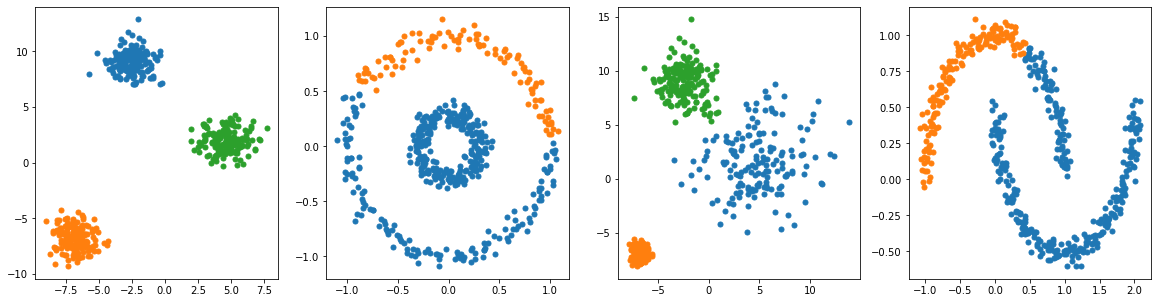

In [8]:
plot_agg_clustering([3, 2, 3, 2], 'ward')

We can also use another linkage method instead of Ward, which we know does not perform well with weird shapes (in principle, we should redraw the dendrograms with this distance metric, but let's just use the "real" number of clusters.

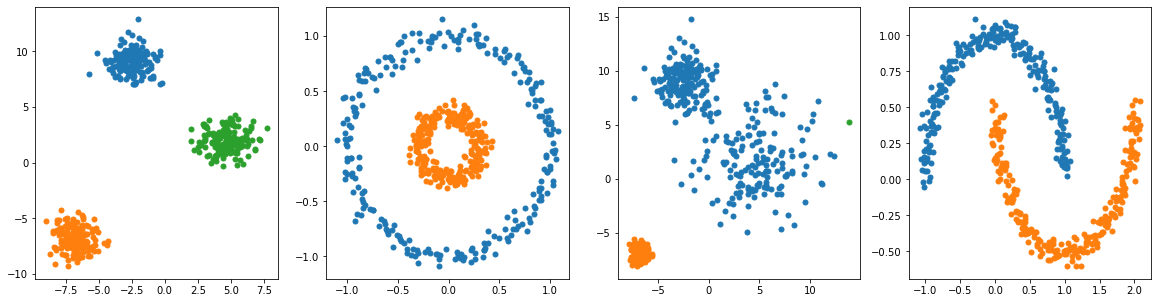

In [9]:
plot_agg_clustering([3, 2, 3, 2], 'single')

This is much better in cases 2 and 4, where the clusters have weird shapes - but single linkage is very sensitive to outliers, as we can see in case 3! The theory matches our experiments! How exotic.

## DBSCAN

Finally, let's use DBSCAN. We'll use minPts = 4 and use the elbow method to find a good value for epsilon:

In [10]:
def calculate_k_distance(X,k): #does this actually work???????
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i,:]-X[j,:]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance

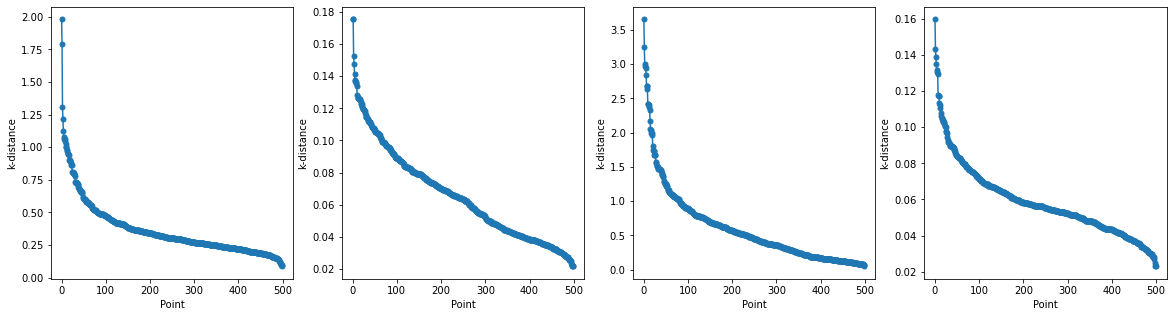

In [11]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(zip(axes.ravel())):
    X = eval("X" + str(i+1))
    k = 4
    k_distances = calculate_k_distance(X,k)
    ax[0].plot(range(len(X)),k_distances,'.-', markersize=10)
    ax[0].set_xlabel('Point')
    ax[0].set_ylabel('k-distance')
plt.show()

From this, we get epsilons of around 1.2, 0.13, 1.6 and 0.12, respectively: The vast majority of points have 4-distances shorter than that. Let's use these values.

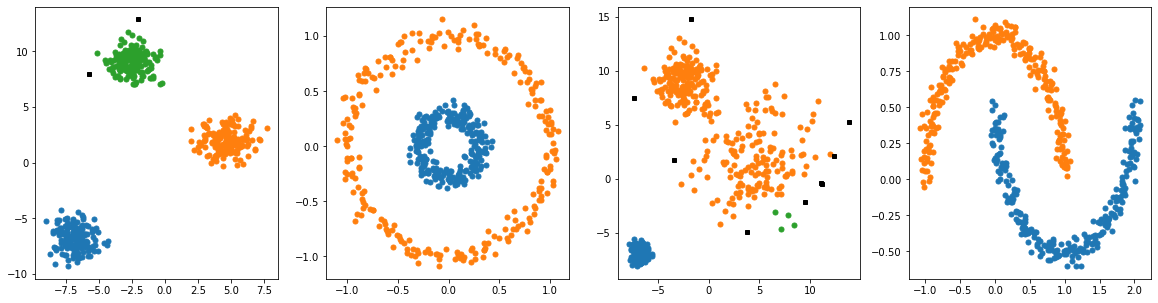

In [12]:
def plot_dbscan(eps):
    fig, axes = plt.subplots(1,4, figsize = (20,5))
    for i, ax in enumerate(zip(axes.ravel())):
        X = eval("X" + str(i+1))
        dbscan = DBSCAN(eps=eps[i], min_samples = 4)
        label = dbscan.fit_predict(X)
        for i in range(k):
            ax[0].plot(X[label == i , 0] , X[label == i , 1], '.', markersize=10, label = i)
        ax[0].plot(X[label == -1 , 0] , X[label == -1 , 1], 'sk', markersize=4, label = -1) #plot outliers as black squares
    plt.show()
    
plot_dbscan([1.2, 0.13, 1.6, 0.12])

DBSCAN works extremely well in cases 1, 2 and 4, but has some issues when clusters are of different densities - as in case  3. We can try to play around with the epsilon value (you are encouraged to do so). With epsilon = 1.5, it does better.

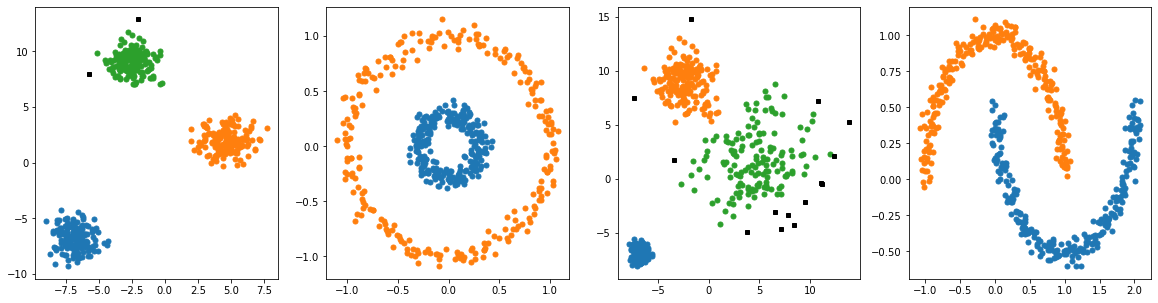

In [13]:
plot_dbscan([1.2, 0.13, 1.5, 0.12])

Ah, much better! This shows how DBSCAN can deal with complex shapes, although we still have some issues with case 3: We can't have it both ways: Either we have a lot of outliers, or the two top clusters merge.